In [36]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent

In [37]:
BATCH_SIZE = 32
IMAGE_SIZE_H = 405
IMAGE_SIZE_W = 720
CHANNELS = 3
EPOCHS = 5

In [46]:
# Load dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "H-pylori-thermal",
    shuffle=True,
    image_size=(IMAGE_SIZE_H, IMAGE_SIZE_W),
    batch_size=BATCH_SIZE
)

Found 4629 files belonging to 2 classes.


In [47]:
class_names = dataset.class_names

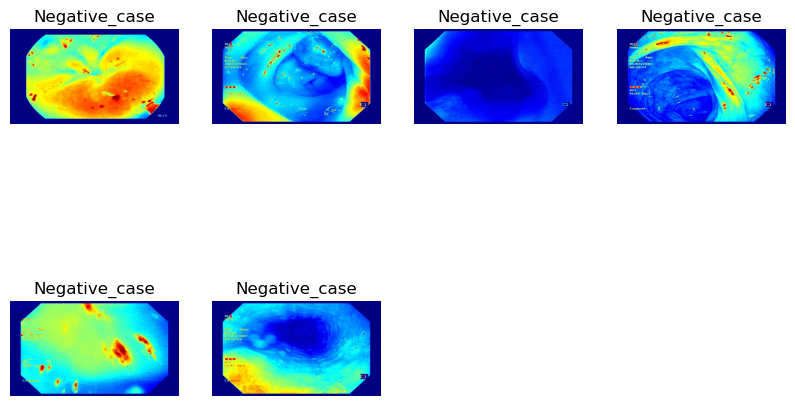

In [48]:
# visualizing some images

plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(6):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [49]:
# Function to partition dataset
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [50]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [51]:
# Cache, shuffle, and prefetch datasets
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [52]:
#to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).
#This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.
#somone can supply an image that is not (256,256) and this layer will resize it

# Creating a Layer for Resizing and Normalization
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMAGE_SIZE_H, IMAGE_SIZE_W),
  tf.keras.layers.Rescaling(1./255),
])


In [53]:
#boost the accuracy of our model by augmenting the data

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
])

In [54]:
# Model definition
input_shape = (BATCH_SIZE, IMAGE_SIZE_H, IMAGE_SIZE_W, CHANNELS)
n_classes = len(class_names)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(IMAGE_SIZE_H, IMAGE_SIZE_W, CHANNELS)),
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation='softmax'),
])


In [55]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)            │ (None, 405, 720, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 403, 718, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 403, 718, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 201, 359, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 199, 357, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 199, 357, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 99, 178, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 97, 176, 128)        │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 97, 176, 128)        │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 48, 88, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 540672)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      69,206,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 69,300,546 (264.36 MB)

 Trainable params: 69,300,098 (264.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [56]:
# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [57]:
# PGD attack function
def pgd_attack(model, images, labels):
    epsilon = 0.1
    alpha = 0.001
    iterations = 20
    return projected_gradient_descent(model, images, eps=epsilon, eps_iter=alpha, nb_iter=iterations, norm=np.inf, clip_min=0, clip_max=1, y=labels)


In [58]:
class PGDAttackCallback(tf.keras.callbacks.Callback):
    def __init__(self, pgd_attack):
        super(PGDAttackCallback, self).__init__()
        self.pgd_attack = pgd_attack
        self.train_batch = None

    def on_train_batch_end(self, batch, logs=None):
        if self.train_batch is None:
            return  # Skip if train_batch is not set
        adv_images = self.pgd_attack(self.model, self.train_batch[0], self.train_batch[1])
        self.train_batch = (tf.concat([self.train_batch[0], adv_images]), 
                            self.train_batch[1])

In [59]:
# Evaluate model on validation set before training
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation Accuracy (Before Training): {val_acc}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.1835 - loss: 0.7249
Validation Accuracy (Before Training): 0.1875


In [60]:
# Training with model.fit and callbacks
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[PGDAttackCallback(pgd_attack)]
)

Epoch 1/5
116/116 ━━━━━━━━━━━━━━━━━━━━ 1841s 15s/step - accuracy: 0.7721 - loss: 19.0830 - val_accuracy: 0.1853 - val_loss: 322.9101
Epoch 2/5
116/116 ━━━━━━━━━━━━━━━━━━━━ 1715s 15s/step - accuracy: 0.8044 - loss: 0.6671 - val_accuracy: 0.1853 - val_loss: 113.5364
Epoch 3/5
116/116 ━━━━━━━━━━━━━━━━━━━━ 1699s 15s/step - accuracy: 0.8051 - loss: 0.5493 - val_accuracy: 0.1853 - val_loss: 28.1899
Epoch 4/5
116/116 ━━━━━━━━━━━━━━━━━━━━ 1712s 15s/step - accuracy: 0.8026 - loss: 0.5689 - val_accuracy: 0.8214 - val_loss: 0.7545
Epoch 5/5
116/116 ━━━━━━━━━━━━━━━━━━━━ 1697s 15s/step - accuracy: 0.8129 - loss: 0.5220 - val_accuracy: 0.8214 - val_loss: 0.4707


In [61]:
# Evaluate model on test set after training
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.8288 - loss: 0.4714
Test Accuracy: 0.8104166388511658


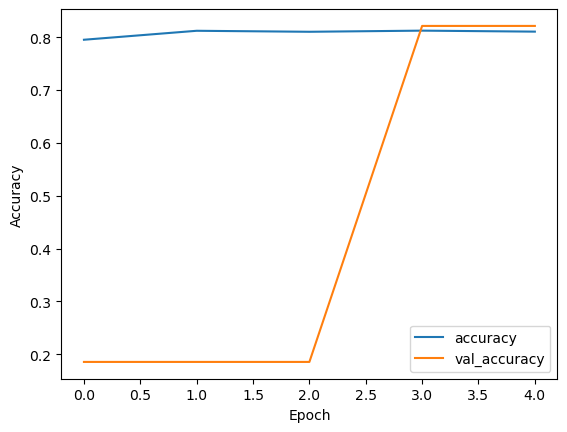

In [62]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [64]:
# Function to display original and adversarial images
def display_images(original_images, adversarial_images, original_labels, adversarial_labels):
    num_images = min(5, len(original_images))
    plt.figure(figsize=(10, 4))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        plt.imshow(original_images[i].numpy().astype("uint8"))
        plt.title(f"Original: {class_names[original_labels[i]]}")
        plt.axis("off")
        
        plt.subplot(2, 5, i + 6)
        plt.imshow(adversarial_images[i].numpy().astype("uint8"))
        plt.title(f"Adversarial: {class_names[adversarial_labels[i]]}")
        plt.axis("off")
    plt.show()

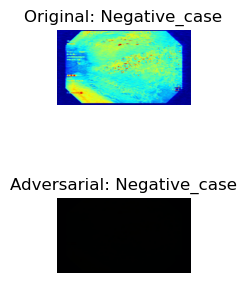

In [65]:
# Display one original and one adversarial image
for batch_images, batch_labels in test_ds.take(1):
    adv_images = pgd_attack(model, batch_images, batch_labels)
    display_images(batch_images[:1], adv_images[:1], batch_labels[:1], batch_labels[:1])

In [43]:
#thermal grading the pictures in the dataset

def apply_thermal_grading(image):
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply the thermal colormap
    thermal_image = cv2.applyColorMap(gray_image, cv2.COLORMAP_JET)
    
    return thermal_image

In [44]:
#creating new folder to save thermal graded pics

import os
import cv2

output_directory = "H-pylori-thermal"
os.makedirs(output_directory, exist_ok=True)

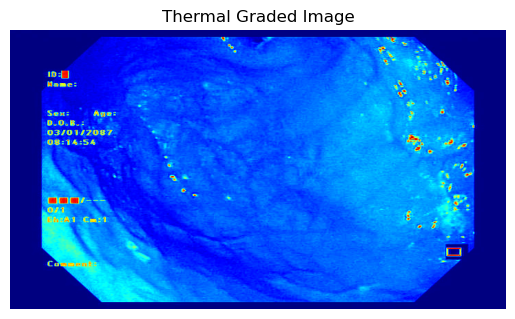

In [45]:
#saving the generated pictures in the respective folders

# Create subdirectories for each class
for class_name in class_names:
    class_dir = os.path.join(output_directory, class_name)
    os.makedirs(class_dir, exist_ok=True)

def save_thermal_images(dataset, output_directory):
    image_counter = 0
    for batch, labels in dataset:
        for i, image in enumerate(batch):
            # Convert the TensorFlow tensor to a numpy array
            image_np = image.numpy().astype(np.uint8)
            
            # Apply thermal grading
            thermal_image = apply_thermal_grading(image_np)
            
            # Get the label of the image
            label = labels[i].numpy()
            class_name = class_names[label]
            
            # Define the output path for the image
            output_path = os.path.join(output_directory, class_name, f"thermal_image_{image_counter}.jpg")
            image_counter += 1
            
            # Save the image using OpenCV
            cv2.imwrite(output_path, thermal_image)

          

save_thermal_images(dataset, output_directory)